# Healthcare (Capstone Project)

**Description:**

ICMR wants to analyze different types of cancers, such as breast cancer, renal cancer, colon cancer, lung cancer, and prostate cancer becoming a cause of worry in recent years. They would like to identify the probable cause of these cancers in terms of genes responsible for each cancer type. This would lead us to early identification of each type of cancer reducing the fatality rate.

**Dataset Details:**

The input dataset contains 801 samples for the corresponding 801 individuals who have been detected with different types of cancer. Each sample contains expression values of more than 20K genes. Samples have one of the types of tumors: BRCA, KIRC, COAD, LUAD, and PRAD.

**Overview:**

![Outline Image](Image.png)

##  Exploratory Data Analysis

In [1]:
# General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis and modeling
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import MultiComparison

# Machine learning and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.datasets import make_classification
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Clustering and dimensionality reduction
from fastcluster import linkage
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Other libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.utils import to_categorical
from tabulate import tabulate

In [2]:
# Import datasets
data = pd.read_csv("data.csv")
labels = pd.read_csv("labels.csv")
# Merge both datasets
df = pd.merge(data, labels, on="Unnamed: 0")

In [3]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Columns: 20533 entries, Unnamed: 0 to Class
dtypes: float64(20531), object(2)
memory usage: 125.6 MB


Dataset is 126.5 MB containing 20531 genes and 801 samples. 

In [4]:
df.columns

Index(['Unnamed: 0', 'gene_0', 'gene_1', 'gene_2', 'gene_3', 'gene_4',
       'gene_5', 'gene_6', 'gene_7', 'gene_8',
       ...
       'gene_20522', 'gene_20523', 'gene_20524', 'gene_20525', 'gene_20526',
       'gene_20527', 'gene_20528', 'gene_20529', 'gene_20530', 'Class'],
      dtype='object', length=20533)

Gene expressions (20531) are provided in the numeric, float format with the first column providing the sample number (object) and the last column (class) providing the type of cancer the tumor is. 

In [5]:
data.describe()

,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,...,gene_20521,gene_20522,gene_20523,gene_20524,gene_20525,gene_20526,gene_20527,gene_20528,gene_20529,gene_20530
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.0,801.000000,801.000000,801.000000,801.000000,...,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,3.010909,3.095350,6.722305,9.813612,0.0,7.405509,0.499882,0.016744,0.013428,...,5.896573,8.765891,10.056252,4.847727,9.741987,11.742228,10.155271,9.590726,5.528177,0.095411
std,0.136850,1.200828,1.065601,0.638819,0.506537,0.0,1.108237,0.508799,0.133635,0.204722,...,0.746399,0.603176,0.379278,2.382728,0.533898,0.670371,0.580569,0.563849,2.073859,0.364529
min,0.000000,0.000000,0.000000,5.009284,8.435999,0.0,3.930747,0.000000,0.000000,0.000000,...,2.853517,6.678368,8.669456,0.000000,7.974942,9.045255,7.530141,7.864533,0.593975,0.000000
25%,0.000000,2.299039,2.390365,6.303346,9.464466,0.0,6.676042,0.000000,0.000000,0.000000,...,5.454926,8.383834,9.826027,3.130750,9.400747,11.315857,9.836525,9.244219,4.092385,0.000000
50%,0.000000,3.143687,3.127006,6.655893,9.791599,0.0,7.450114,0.443076,0.000000,0.000000,...,5.972582,8.784144,10.066385,5.444935,9.784524,11.749802,10.191207,9.566511,5.218618,0.000000
75%,0.000000,3.883484,3.802534,7.038447,10.142324,0.0,8.121984,0.789354,0.000000,0.000000,...,6.411292,9.147136,10.299025,6.637412,10.082269,12.177852,10.578561,9.917888,6.876382,0.000000
max,1.482332,6.237034,6.063484,10.129528,11.355621,0.0,10.718190,2.779008,1.785592,4.067604,...,7.771054,11.105431,11.318243,9.207495,11.811632,13.715361,11.675653,12.813320,11.205836,5.254133


### Plot the merged dataset as a hierarchically-clusterd heatmap

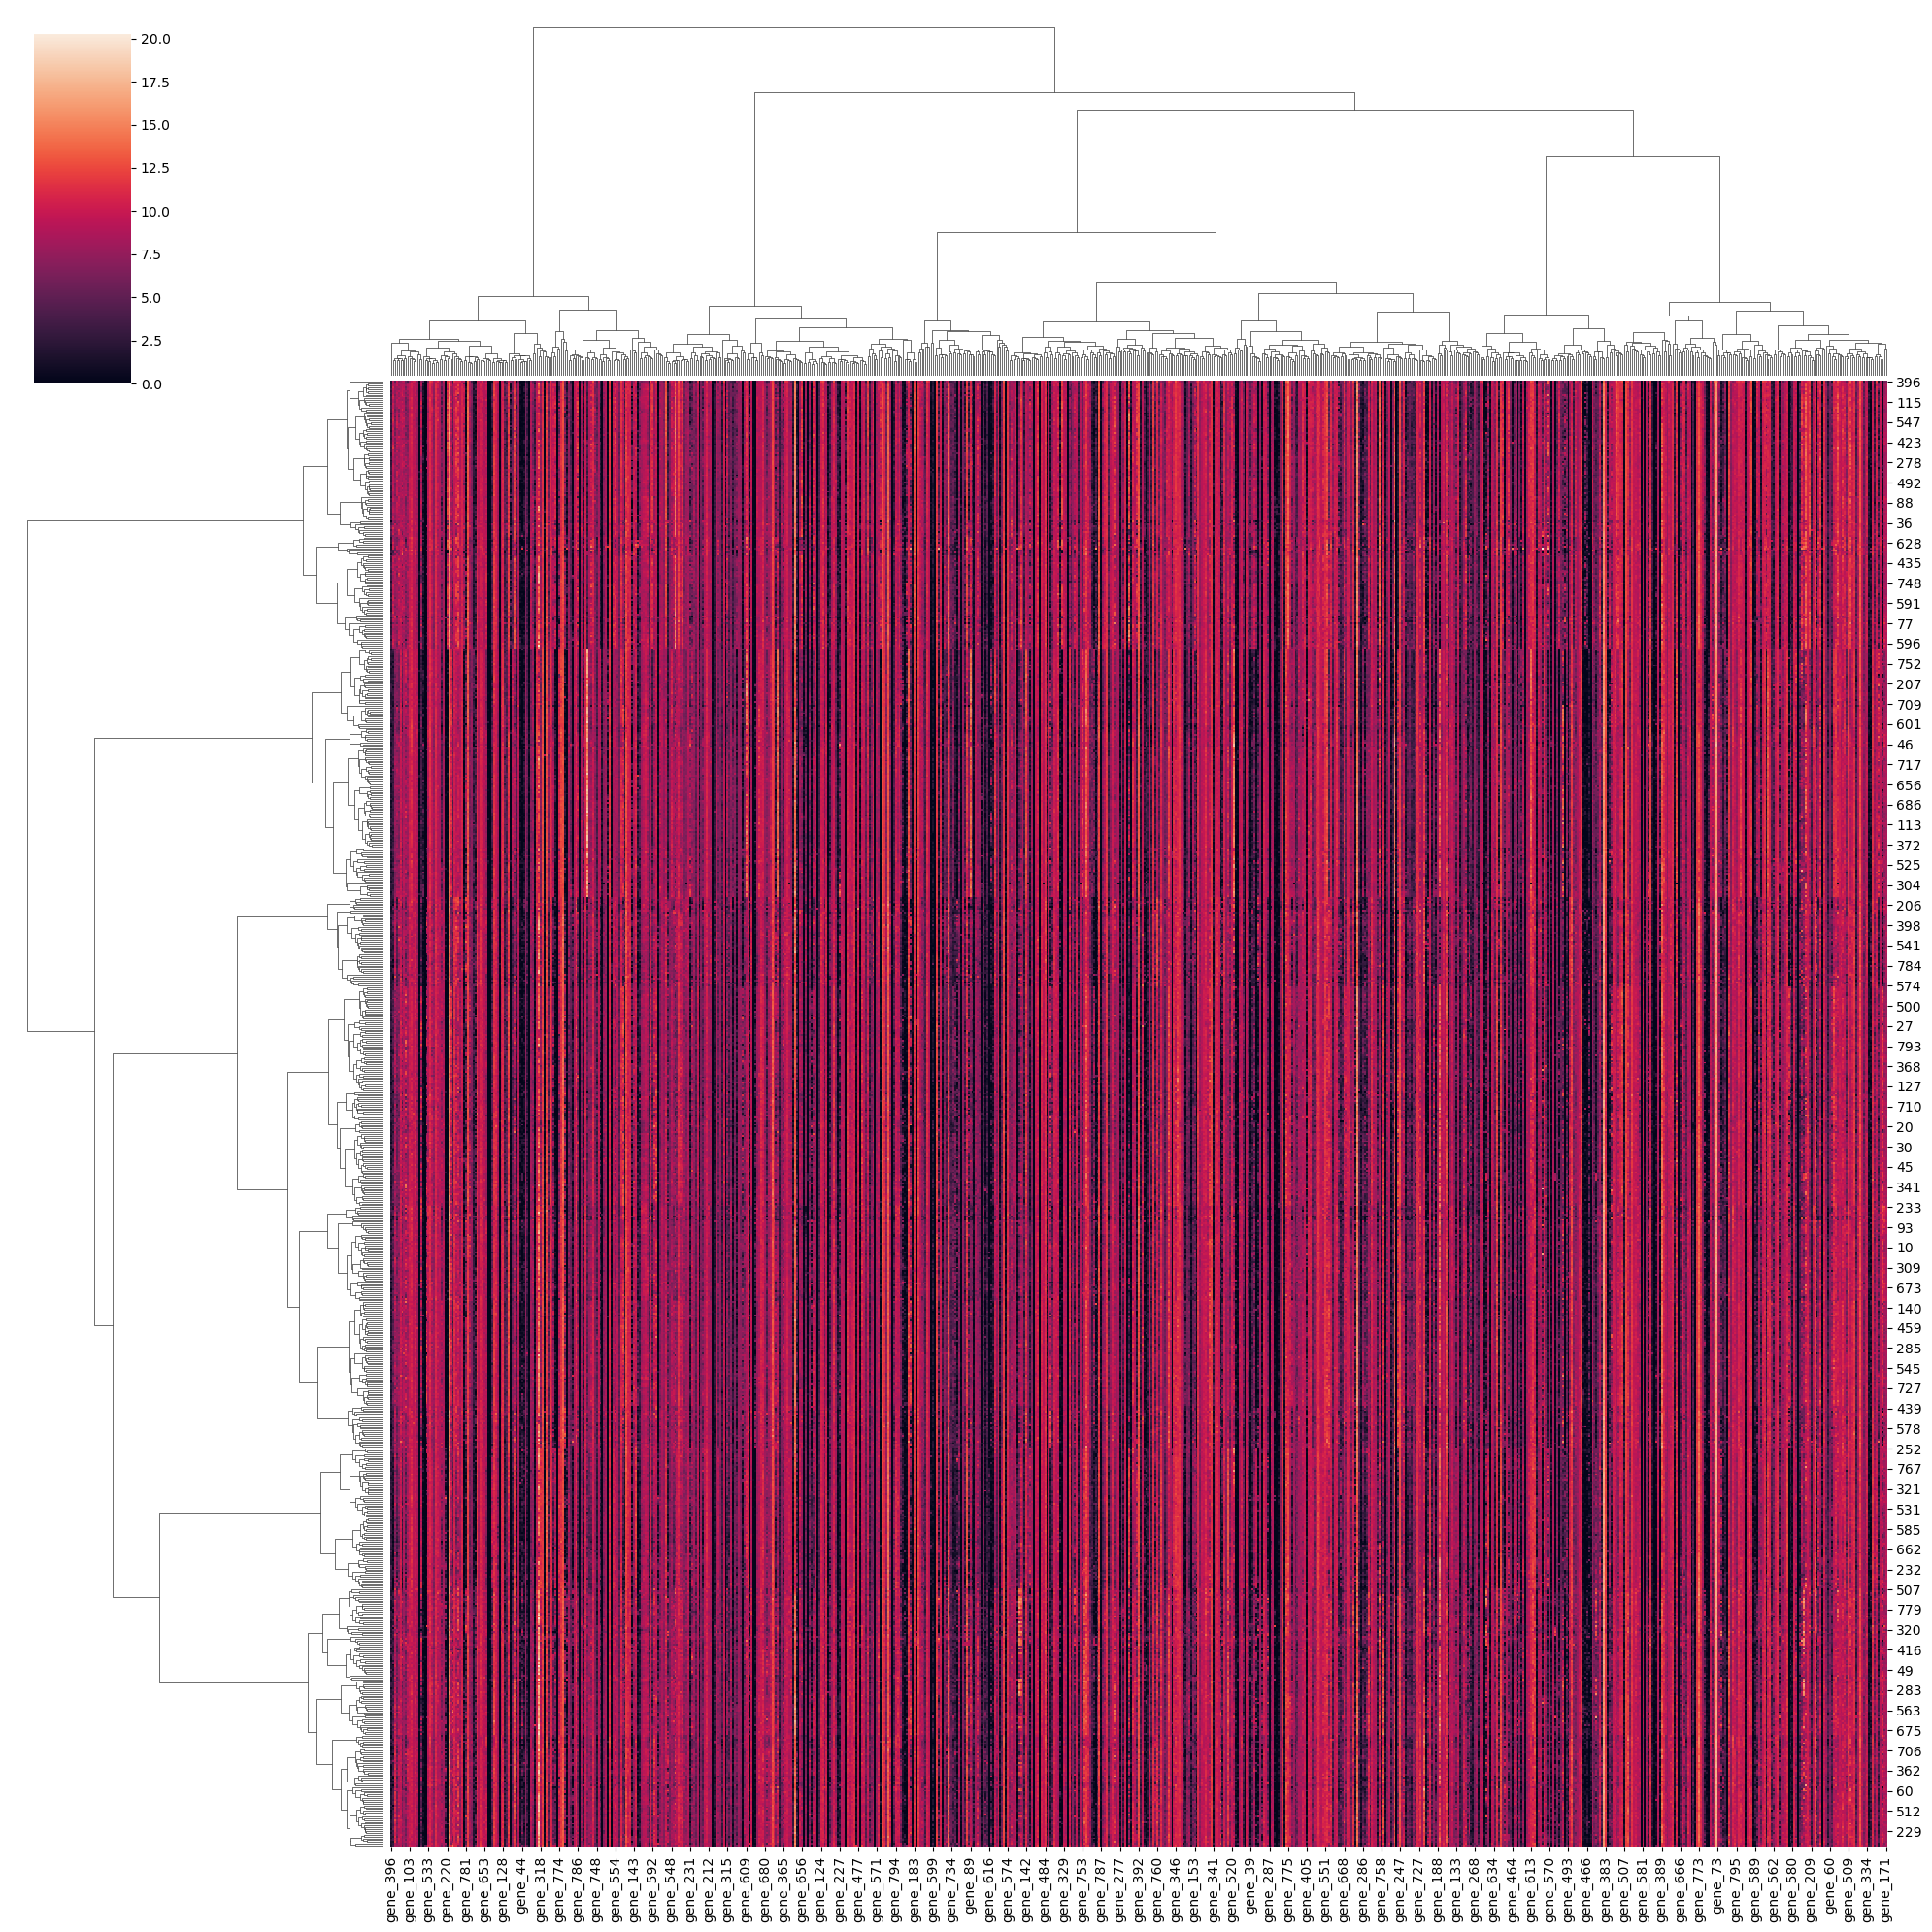

In [6]:
# Sperate dataset into numerical data
df_num = df.iloc[:,1:-1]
# Utilizing ward linkage (sum of squared differneces within all clusters)
clusters = linkage(df_num, method='ward')
# Creating clustermap to visually inspect hierarchical clustering and heatmap
sns.clustermap(df_num, row_linkage=clusters, col_linkage=clusters, figsize=(20,20))
plt.show()

There is an abundant amount of correlation (red) represented in the heat map between genes, however, there are also several genes with no correlation (black), therefore, there is need of removal of genes as there is no significance of them when trying to compare similarities of gene expression to the cancer types.

### Perform Null-Hypothesis testing

**Null Hypothesis:** Cancer types using tumor types (BRCA, KIRC, COAD, LUAD, & PRAD) cannot be correlated with the the genetic makeups in the dataset as there is no significant evidence. 

**Alternative Hypothesis:** Cancer types using tumor types (BRCA, KIRC, COAD, LUAD, & PRAD) can be correlated with the the genetic makeups in the dataset as there is significant evidence. 

In [7]:
# Group samples based off tumor type
brca_df = df[df['Class'] == 'BRCA'].select_dtypes(include=np.number)
kirc_df = df[df['Class'] == 'KIRC'].select_dtypes(include=np.number)
coad_df = df[df['Class'] == 'COAD'].select_dtypes(include=np.number)
luad_df = df[df['Class'] == 'LUAD'].select_dtypes(include=np.number)
prad_df = df[df['Class'] == 'PRAD'].select_dtypes(include=np.number)

# Find mean value expression for each tumor type
brca = brca_df.mean()
kirc = kirc_df.mean()
coad = coad_df.mean()
prad = prad_df.mean()
luad = luad_df.mean()
# Create a dataframe with mean values
means_df = pd.DataFrame({'BRCA': brca, 'KIRC': kirc, 'COAD': coad, 'PRAD': prad, 'LUAD': luad})
# Format df with pd.melt
format_df = pd.melt(means_df, var_name='Cancer_Type', value_name='Gene_Expression')

# Create ANOVA model
model = ols('Gene_Expression ~ C(Cancer_Type)', data=format_df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model)
# See ANOVA
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Cancer_Type),4.0,6.510021e+02,162.750526,10.537943,1.557708e-08
Residual,102650.0,1.585351e+06,15.444241,NaN,NaN


ANOVA results conclude that there is enough significant evidence to reject the null hypothesis (p=0.000000015).

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  BRCA   COAD   -0.119 0.0184 -0.2248 -0.0132   True
  BRCA   KIRC   0.0643 0.4604 -0.0415  0.1701  False
  BRCA   LUAD   0.1152 0.0249  0.0093   0.221   True
  BRCA   PRAD   0.0518 0.6686  -0.054  0.1576  False
  COAD   KIRC   0.1833    0.0  0.0775  0.2891   True
  COAD   LUAD   0.2341    0.0  0.1283  0.3399   True
  COAD   PRAD   0.1708 0.0001   0.065  0.2766   True
  KIRC   LUAD   0.0509 0.6844  -0.055  0.1567  False
  KIRC   PRAD  -0.0125 0.9977 -0.1183  0.0933  False
  LUAD   PRAD  -0.0633 0.4763 -0.1691  0.0425  False
----------------------------------------------------


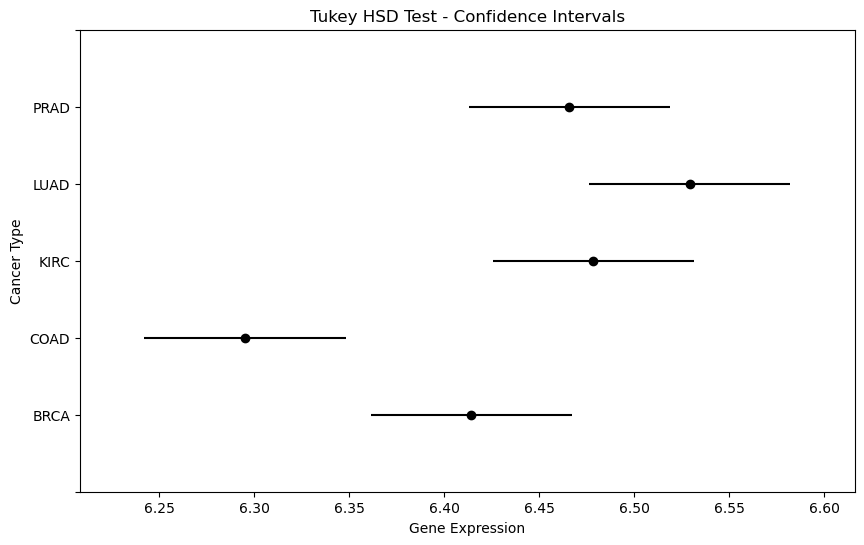

In [8]:
# Create a MultiComparison object
multi_comp = MultiComparison(format_df['Gene_Expression'], format_df['Cancer_Type'])

# Perform Tukey's HSD test
tukey_results = multi_comp.tukeyhsd()

# Plot the confidence intervals
tukey_results.plot_simultaneous()

# Add labels and title
plt.xlabel('Gene Expression')
plt.ylabel('Cancer Type')
plt.title('Tukey HSD Test - Confidence Intervals')

# Show the plot
print(tukey_results)
plt.show()

For further analysis, a Tukey's HSD test is performed to conclude that the COAD (colon cancer) is significanly different to the rest of the groups. Meanwhile, BRCA and LUAD are significanly different from each other. There is strong evidence of gene expression differences in the comparisons of BRCA and COAD, COAD and KIRC, COAD and PRAD, BRCA and LUAD, and COAD and LUAD. These findings signify that COAD does have unique gene expression characteristics. 

## Dimensionality Reduction

Each sample has expression values for around 20K genes. However, it may not be necessary to include all 20K genes expression values to analyze each cancer type. Therefore, we will identify a smaller set of attributes which will then be used to fit multiclass classification models.The first task targets the dimensionality reduction using various techniques such as **Principal Component Analysis (PCA)**, **Linear Discriminant Analysis (LDA)**, and **t-distributed Stochastic Neighbor Embedding (t-SNE)**. Performance will be based on visual inspection as it is difficult to compare these techniques with metrics as t-SNE is ideal for non-linear relationship, whereas PCA and LDA are used for linear relationships. Explained variance will be calculated for PCA and LDA, and KL divergence will be calculated for t-SNE. Explained variance is an array with two scores between 0 and 1 showing the proportion of variance on each principle component relative to the original data. Ideally, a score closer to 1 indicates better results. The KL divergence score serves as a lost function to measure the discrepancy between the high-dimensional and low-dimensional probability distributions. To reiterate, these metrics are will not be used to determine the superiority of any technique.

In [9]:
# Seperating Dataframe into two
genes = df.iloc[:,1:-1]
cancers = df['Class']

### Principal Component Analysis (PCA)

In [10]:
# Create PCA instance 
pca = PCA(n_components=2)
# Fit PCA
pca_fit = pca.fit_transform(genes)

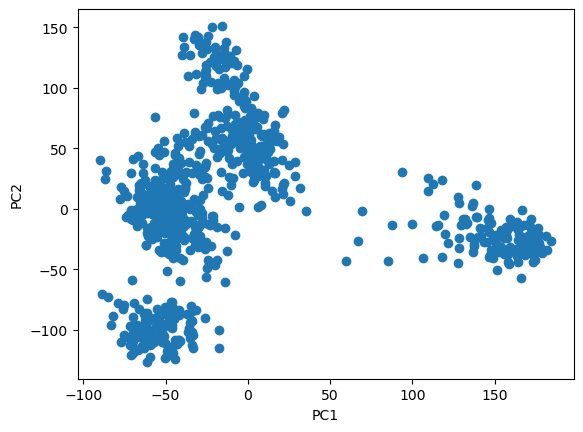

In [11]:
# Visualize PCA
plt.scatter(pca_fit[:,0],pca_fit[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [12]:
# Explained Variance
var = pca.explained_variance_ratio_
var

array([0.1583855, 0.1050396])

### Linear Discriminant Alalysis (LDA)

In [13]:
# Create Instance for LDA
lda = LinearDiscriminantAnalysis(n_components=2)
# Fit LDA 
lda_fit = lda.fit_transform(genes, cancers)

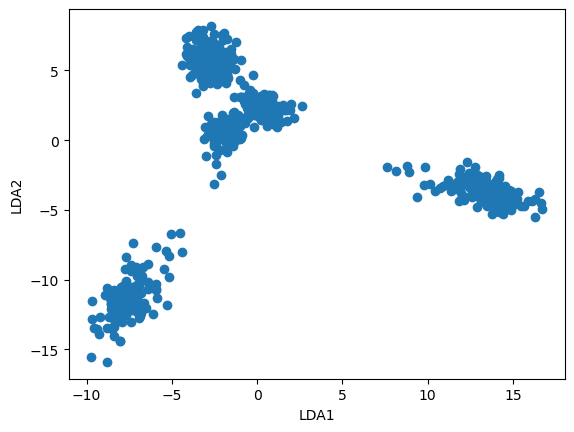

In [14]:
# Visualize LDA 
plt.scatter(lda_fit[:,0],lda_fit[:,1])
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.show()

In [15]:
# Explained Variance
var1 = lda.explained_variance_ratio_
var1

array([0.36219022, 0.30156109])

### t-SNE

In [16]:
# Create Instance for t-SNE
tsne = TSNE(n_components=2, random_state=42)
# Fit t-SNE
tsne_fit = tsne.fit_transform(genes)

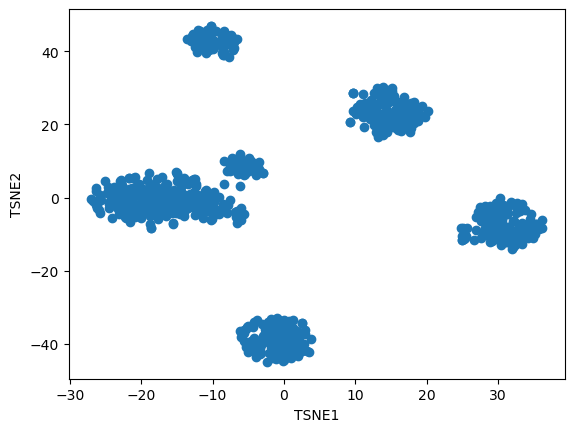

In [17]:
# Visualize t-SNE
plt.scatter(tsne_fit[:,0],tsne_fit[:,1])
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

In [18]:
# KL Divergence
var2 = np.sum(tsne.kl_divergence_)
var2

0.6838566064834595

In [19]:
# Access the embedding
tsne_embedding = tsne.embedding_
selected_genes_indices = np.argsort(tsne_embedding[:, 1])
# Retrieve gene names
gene_names = genes.columns
# Retrieve the names of the selected genes
selected_genes = gene_names[selected_genes_indices]

In [20]:
selected_genes

Index(['gene_9', 'gene_377', 'gene_231', 'gene_709', 'gene_184', 'gene_401',
       'gene_788', 'gene_2', 'gene_205', 'gene_265',
       ...
       'gene_272', 'gene_371', 'gene_132', 'gene_652', 'gene_54', 'gene_444',
       'gene_308', 'gene_47', 'gene_383', 'gene_530'],
      dtype='object', length=801)

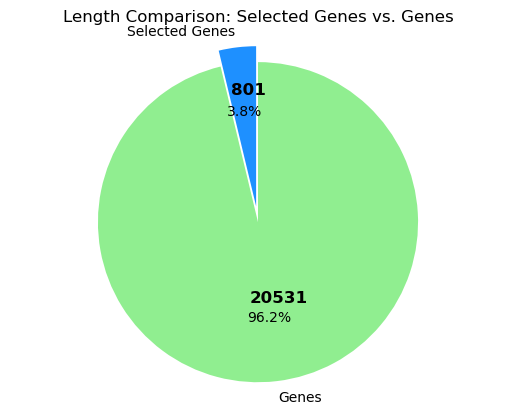

In [21]:
# Get the lengths of selected_genes and gene_names
selected_genes_length = len(selected_genes)
gene_names_length = len(gene_names)

# Create a pie chart
labels = ['Selected Genes', 'Genes']
sizes = [selected_genes_length, gene_names_length]
colors = ['dodgerblue', 'lightgreen']
explode = (0.1, 0)  # explode the 'Selected Genes' slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Length Comparison: Selected Genes vs. Genes')

# Add length values as annotations
plt.text(-0.17, .8, str(selected_genes_length), color='black', fontsize=12, fontweight='bold')
plt.text(-0.05, -.5, str(gene_names_length), color='black', fontsize=12, fontweight='bold')

# Display the pie chart
plt.axis('equal')
plt.show()

#### The t-SNE technique will be used. The pie chart effectively illustrates the proportion of genes that have a significant effect on cancer types. Out of 20531 genes, 801 will be used.



## Clustering Genes and Samples

Our next goal is to identify groups of genes that behave similarly across samples and identify the distribution of samples corresponding to each cancer type. Therefore, this task focuses on applying various clustering techniques, e.g., k-means, hierarchical, and mean-shift clustering, on genes and samples.

### Clustering Technique Testing

#### K-Means Clustering

In [22]:
# Create Instance for K-means 
km = KMeans(n_clusters=5, random_state=42, n_init=10)
# Fit 
km.fit(tsne_fit)
km_labels = km.labels_

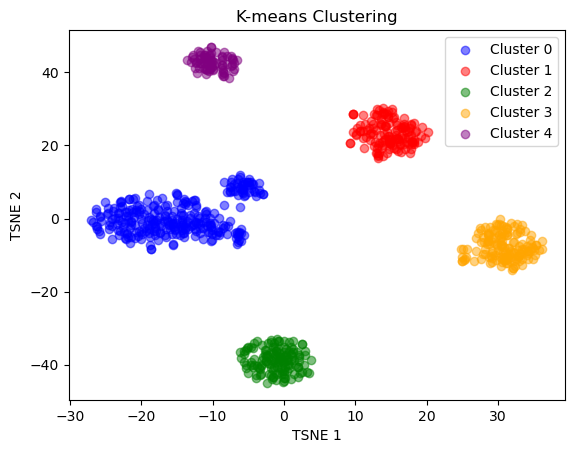

In [23]:
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in enumerate(colors):
    plt.scatter(tsne_fit[km.labels_==i, 0], tsne_fit[km.labels_==i, 1], color=color, alpha=0.5, label=f'Cluster {i}')
plt.legend()
plt.xlabel('TSNE 1')
plt.ylabel('TSNE 2')
plt.title('K-means Clustering')
plt.show()

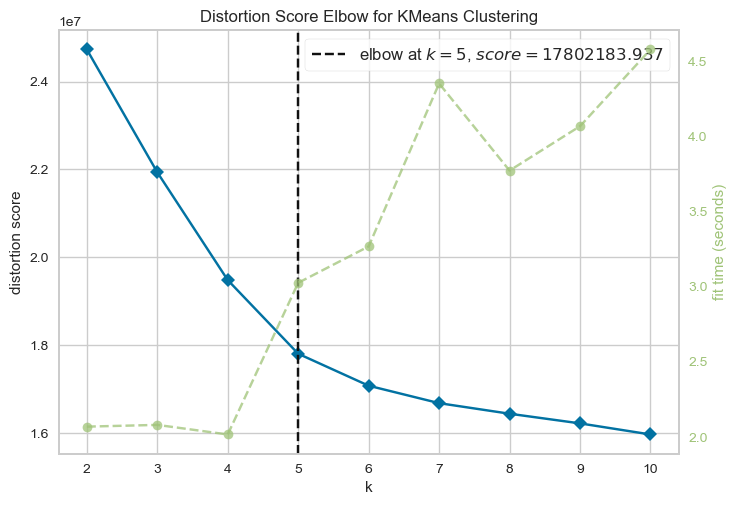

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [24]:
# Elbow Method to determine correct cluster number (k)
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(km)
visualizer.fit(genes) 
visualizer.show()

For validation, the elbow method (KElbowVisualizer technique) is utilized to determine the best amount of clusters (k=5).

#### Hierarcical Clustering

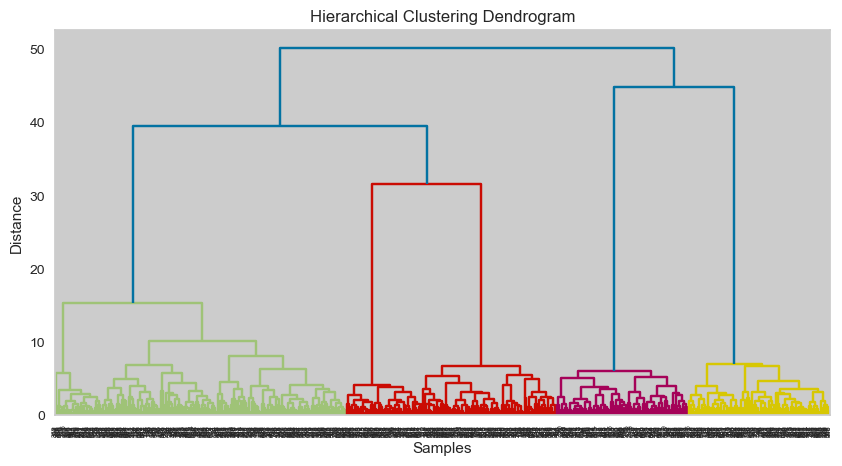

In [25]:
# calculate pairwise distances between samples using Euclidean distance
distances = hierarchy.distance.pdist(tsne_fit, metric='euclidean')

# perform hierarchical clustering using complete linkage
Z = hierarchy.linkage(distances, method='average')

# plot dendrogram
plt.figure(figsize=(10, 5))
dn = hierarchy.dendrogram(Z)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

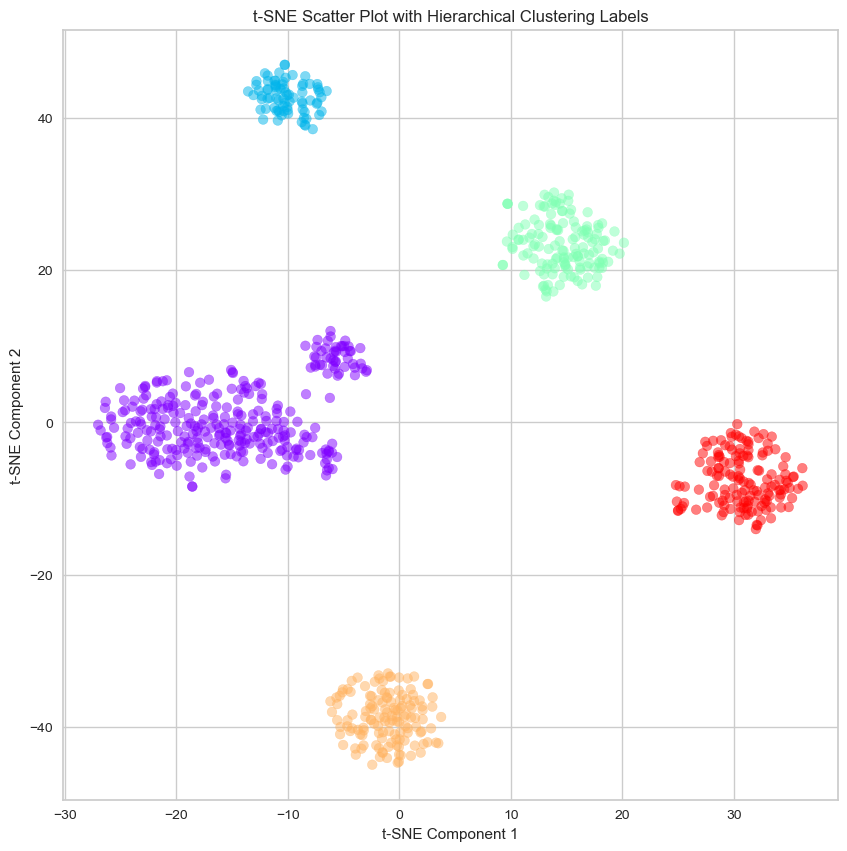

In [26]:
# extract cluster labels for each sample
max_d = 30
h_labels = hierarchy.fcluster(Z, max_d, criterion='distance')

# plot scatter plot with colored clusters
plt.figure(figsize=(10, 10))
plt.scatter(tsne_fit[:, 0], tsne_fit[:, 1], c=h_labels, cmap='rainbow', alpha=0.5)
plt.title('t-SNE Scatter Plot with Hierarchical Clustering Labels')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()

#### Mean-Shift Clustering

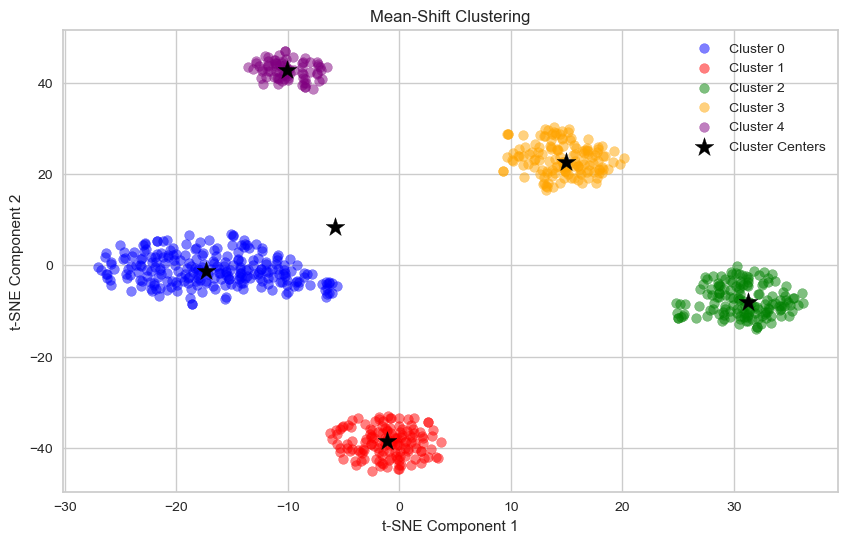

In [27]:
bandwidth = estimate_bandwidth(tsne_fit, quantile=0.1, n_samples=500)
# perform mean-shift clustering
ms = MeanShift(bandwidth=bandwidth)
ms.fit(tsne_fit)

# get the cluster labels and centers
ms_labels = ms.labels_
ms_centers = ms.cluster_centers_

# plot the clusters in a scatter plot
plt.figure(figsize=(10, 6))
colors = ['blue', 'red', 'green', 'orange', 'purple']
for i, color in enumerate(colors):
    plt.scatter(tsne_fit[ms_labels==i, 0], tsne_fit[ms_labels==i, 1], color=color, alpha=0.5, label=f'Cluster {i}')
plt.scatter(ms_centers[:, 0], ms_centers[:, 1], color='black', marker='*', s=200, label='Cluster Centers')
plt.legend()
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Mean-Shift Clustering')
plt.show()

### Choosing Clustering Technique

In [28]:
# Silhouette Coefficient for K-means
sil_avg = silhouette_score(tsne_fit, km_labels)
# Silhouette Coefficient for Hierarchical
sil_avg1 = silhouette_score(tsne_fit, h_labels)
# Silhouette Coefficient for Mean-Shift
sil_avg2 = silhouette_score(tsne_fit, ms_labels)
# Calinkski-Harabasz Index for K-means
ch_score = calinski_harabasz_score(tsne_fit, km_labels)
# Calinkski-Harabasz Index for Hierarchical
ch_score1 = calinski_harabasz_score(tsne_fit, h_labels)
# Calinkski-Harabasz Index for Mean-Shift
ch_score2 = calinski_harabasz_score(tsne_fit, ms_labels)
# Davies Boulin Score for K-means
db_index = davies_bouldin_score(genes, km_labels)
# Davies Bouldin Score for Hierarchical
db_index1 = davies_bouldin_score(genes, h_labels)
# Davies Bouldin Score for Mean-Shift
db_index2 = davies_bouldin_score(genes, ms_labels)

In [29]:
# Visualize and compare scores
comparison_table = pd.DataFrame(columns=["Metric","K-Means", "Hierarchical Clustering", "Mean-Shift"])
comparison_table["Metric"] = ["Average Silhouette Coefficient","Calinski-Harabasz Index","Davies Bouldin Score"]
comparison_table["K-Means"] = sil_avg, ch_score, db_index
comparison_table["Hierarchical Clustering"] = sil_avg1, ch_score1, db_index1
comparison_table["Mean-Shift"] = sil_avg2, ch_score2,db_index2

print(tabulate(comparison_table, headers= 'keys', tablefmt = 'psql', numalign="left"))

+----+--------------------------------+-----------+---------------------------+--------------+
|    | Metric                         | K-Means   | Hierarchical Clustering   | Mean-Shift   |
|----+--------------------------------+-----------+---------------------------+--------------|
| 0  | Average Silhouette Coefficient | 0.804353  | 0.804353                  | 0.715687     |
| 1  | Calinski-Harabasz Index        | 5121.6    | 5121.6                    | 6143.56      |
| 2  | Davies Bouldin Score           | 1.83083   | 1.83083                   | 1.96753      |
+----+--------------------------------+-----------+---------------------------+--------------+


#### Both the K-Means and Hierarchical Clustering Techniques work well, therefore, K-Means will be used from now on. 

### Clustering Genes and Samples

#### Genes whose expression values are similar across all samples

In [30]:
# Genes whose expression values are similar across all samples
gene_expression_means = np.mean(genes, axis=0)

# Filter genes based on cluster labels
cluster_mask = np.logical_or.reduce([km_labels == i for i in range(5)])
# Locates selected genes from original dataframe
selected_genes = genes[cluster_mask]
# Calculate variance for selected genes
variance = np.var(selected_genes, axis=0)
# Genes whose expression values are similar across all samples
gene_names = genes.columns
threshold = .5
gene_expression_variance = np.var(genes, axis=0)
low_variance_genes = gene_expression_variance < threshold  # Adjust the threshold as needed
high_variance_genes = gene_expression_variance > threshold
similar_genes = gene_names[low_variance_genes]  # Replace gene_names with the actual names of genes
similar_genes

Index(['gene_0', 'gene_3', 'gene_4', 'gene_5', 'gene_7', 'gene_8', 'gene_9',
       'gene_12', 'gene_13', 'gene_14',
       ...
       'gene_20516', 'gene_20517', 'gene_20518', 'gene_20522', 'gene_20523',
       'gene_20525', 'gene_20526', 'gene_20527', 'gene_20528', 'gene_20530'],
      dtype='object', length=7615)

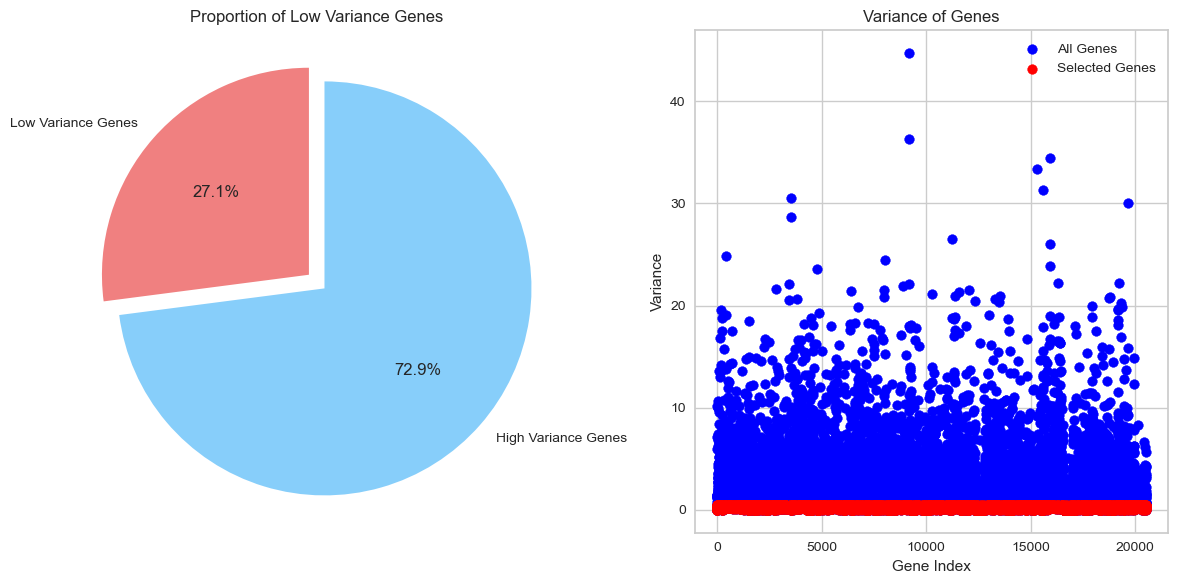

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the pie chart
labels = ['Low Variance Genes', 'High Variance Genes']
sizes = [len(similar_genes), len(high_variance_genes)]
colors = ['lightcoral', 'lightskyblue']
explode = (0.1, 0)

ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
ax1.set_title('Proportion of Low Variance Genes')

# Plot the scatter plot
x = np.arange(len(variance))
ax2.scatter(x, variance, color='blue', label='All Genes')
ax2.scatter(x[low_variance_genes], variance[low_variance_genes], color='red', label='Selected Genes')
ax2.set_xlabel('Gene Index')
ax2.set_ylabel('Variance')
ax2.set_title('Variance of Genes')
ax2.legend()

plt.tight_layout()
plt.show()

#### Genes whose expression values are similar across all samples of each cancer type

In [32]:
# Genes whose expression values are similar across samples of each cancer type 
brca_df = df[df['Class'] == 'BRCA'].select_dtypes(include=np.number)
kirc_df = df[df['Class'] == 'KIRC'].select_dtypes(include=np.number)
coad_df = df[df['Class'] == 'COAD'].select_dtypes(include=np.number)
luad_df = df[df['Class'] == 'LUAD'].select_dtypes(include=np.number)
prad_df = df[df['Class'] == 'PRAD'].select_dtypes(include=np.number)

# Exclude the sample ID/cancer type columns
brca_clusters = km.fit_predict(brca_df.iloc[:, 1:-1]) 
coad_clusters = km.fit_predict(coad_df.iloc[:, 1:-1])
kirc_clusters = km.fit_predict(kirc_df.iloc[:, 1:-1])
luad_clusters = km.fit_predict(luad_df.iloc[:, 1:-1])
prad_clusters = km.fit_predict(prad_df.iloc[:, 1:-1])

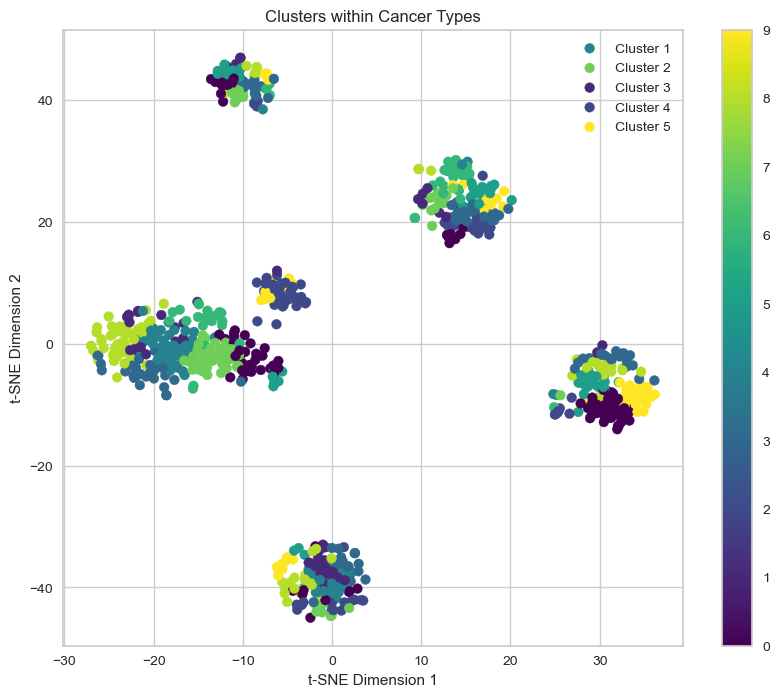

In [33]:
plt.figure(figsize=(10, 8))

# Plot cluster for BRCA
plt.scatter(tsne_fit[brca_df.index, 0], tsne_fit[brca_df.index, 1], c=brca_clusters, cmap='viridis')
# Plot cluster for COAD
plt.scatter(tsne_fit[coad_df.index, 0], tsne_fit[coad_df.index, 1], c=coad_clusters, cmap='viridis')
# Plot cluster for KIRC
plt.scatter(tsne_fit[kirc_df.index, 0], tsne_fit[kirc_df.index, 1], c=kirc_clusters, cmap='viridis')
# Plot cluster for LUAD
plt.scatter(tsne_fit[luad_df.index, 0], tsne_fit[luad_df.index, 1], c=luad_clusters, cmap='viridis')
# Plot cluster for PRAD
plt.scatter(tsne_fit[prad_df.index, 0], tsne_fit[prad_df.index, 1], c=prad_clusters, cmap='viridis')
# Plot Characteristics
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Clusters within Cancer Types')
plt.legend(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'])
plt.colorbar()
plt.show()

#### Samples of the same class (cancer type) which also correspond to the same cluster

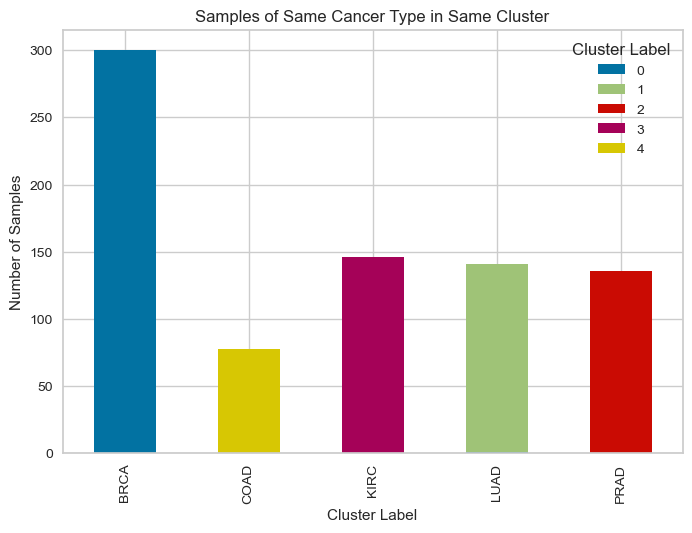

In [34]:
# Samples of same class (cancer type) which also correspond to the same cluster
same_class_same_cluster_samples = []
for cluster_label in range(5):
    cluster_mask = km_labels == cluster_label
    class_labels_in_cluster = cancers[cluster_mask]
    unique_classes_in_cluster = np.unique(class_labels_in_cluster)
    for class_label in unique_classes_in_cluster:
        class_mask = cancers == class_label
        samples_in_class_and_cluster = np.logical_and(cluster_mask, class_mask)
        if np.any(samples_in_class_and_cluster):
            indices = np.where(samples_in_class_and_cluster)[0]
            same_class_same_cluster_samples.extend([(class_label, cluster_label, idx) for idx in indices])
# Create Dataframe
df_same_cluster = pd.DataFrame(same_class_same_cluster_samples, columns=['Cancer Type', 'Cluster Label', 'Sample Index'])
# Visualize dataframe
df_same_cluster      
import matplotlib.pyplot as plt

# Count the number of samples for each combination of cancer type and cluster label
counts = df_same_cluster.groupby(['Cancer Type', 'Cluster Label']).size().unstack()

# Plot the bar chart
counts.plot(kind='bar', stacked=True)

# Set the labels and title
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Samples of Same Cancer Type in Same Cluster')

# Show the plot
plt.show()

#### Samples identified to be belonging to another cluster but also to the same class (cancer type)

In [35]:
same_class_other_cluster_samples = []
for cluster_label in range(5):
    cluster_mask = km_labels == cluster_label
    class_labels_in_cluster = cancers[cluster_mask]
    unique_classes_in_cluster = np.unique(class_labels_in_cluster)
    for class_label in unique_classes_in_cluster:
        class_mask = cancers == class_label
        samples_in_class_other_cluster = np.logical_and(np.logical_not(cluster_mask), class_mask)
        if np.any(samples_in_class_other_cluster):
            indices = np.where(samples_in_class_other_cluster)[0]
            same_class_other_cluster_samples.extend([(class_label, cluster_label, idx) for idx in indices])

df_other_cluster = pd.DataFrame(same_class_other_cluster_samples, columns=['Cancer Type', 'Cluster Label', 'Sample Index'])
df_other_cluster

,Cancer Type,Cluster Label,Sample Index
0,LUAD,0,1
1,LUAD,0,16
2,LUAD,0,22
3,LUAD,0,25
4,LUAD,0,37
...,...,...,...
136,LUAD,0,779
137,LUAD,0,780
138,LUAD,0,795
139,LUAD,0,797


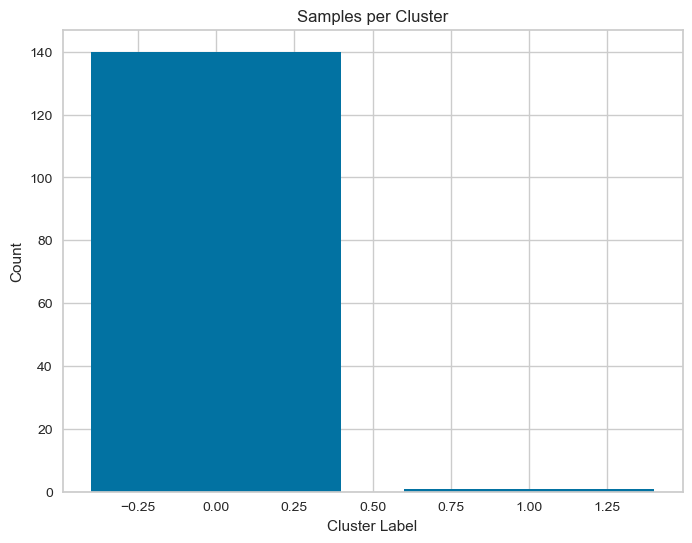

In [36]:
cluster_counts = df_other_cluster['Cluster Label'].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))

# Bar graph
ax.bar(cluster_counts.index, cluster_counts.values)
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Count')
ax.set_title('Samples per Cluster')
plt.show()

## Building Classification Model(s) with Feature Selection:

In [38]:
# Split data into training and testing sets
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(tsne_fit, km_labels, test_size = 0.33, random_state=42)

X_train_rfc, X_test_rfc, y_train_rfc, y_test_rfc = train_test_split(tsne_fit, km_labels, test_size = 0.33, random_state=42)

X_train_dnn, X_test_dnn, y_train_dnn, y_test_dnn = train_test_split(tsne_fit, km_labels, test_size = 0.33, random_state=42)

### Support Vector Machine (SVM) Classifier

In [39]:
# Initialize the SVM classifier
svm_clf = SVC()

# Fit the SVM classifier on the selected features
svm_clf.fit(X_train_svm, y_train_svm)

SVC()

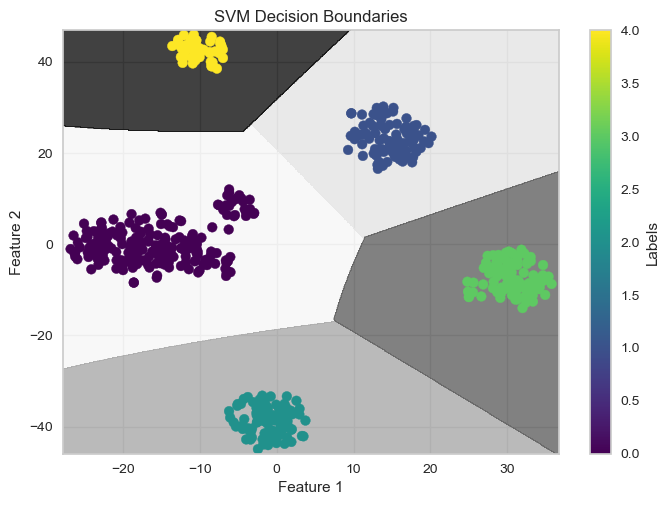

In [40]:
# Create a meshgrid of points spanning the feature space
x_min, x_max = X_train_svm[:, 0].min() - 1, X_train_svm[:, 0].max() + 1
y_min, y_max = X_train_svm[:, 1].min() - 1, X_train_svm[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Obtain the predicted labels for the meshgrid points
Z = svm_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries and the training data
plt.contourf(xx, yy, Z, alpha=0.8)
plt.scatter(X_train_svm[:, 0], X_train_svm[:, 1], c=y_train_svm, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundaries')
plt.colorbar(label='Labels')
plt.show()

In [41]:
# Predict the labels for the test set
svm_pred = svm_clf.predict(X_test_svm)

# Calculate the accuracy of the SVM classifier
svm_accuracy = accuracy_score(y_test_svm, svm_pred)

svm_accuracy

1.0

### Random Forest Classifier

![Outline Image](ForwardSelection.png)

In [42]:
# Initialize the Random Forest classifier
rf_clf = RandomForestClassifier()

# Initialize the forward feature selector
forward_selector = SequentialFeatureSelector(rf_clf, k_features='best', forward=True, scoring='accuracy', cv=5)

# Perform forward feature selection
forward_selector.fit(X_train_rfc, y_train_rfc)

# Get the selected feature indices
selected_feature_indices = forward_selector.k_feature_idx_

# Retrieve the selected features from the training set
X_train_selected_rfc = X_train_rfc[:, selected_feature_indices]
X_test_selected_rfc = X_test_rfc[:, selected_feature_indices]

# Fit the Random Forest classifier on the selected features
rf_clf.fit(X_train_selected_rfc, y_train_rfc)

# Predict the labels for the test set
rf_pred = rf_clf.predict(X_test_selected_rfc)

# Calculate the accuracy of the Random Forest classifier
rf_accuracy = accuracy_score(y_test_rfc, rf_pred)

rf_accuracy

1.0

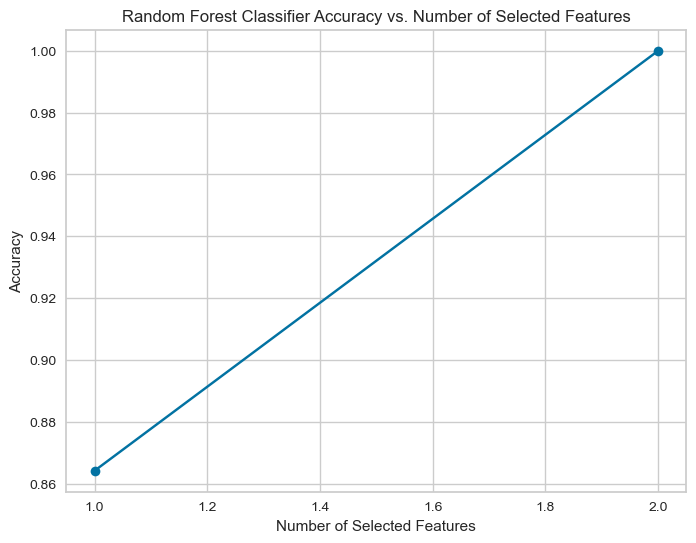

In [43]:
# Perform forward feature selection and track accuracy scores
accuracy_scores = []
num_features = range(1, len(selected_feature_indices) + 1)
for k in num_features:
    X_train_selected_rfc = X_train_rfc[:, selected_feature_indices[:k]]
    X_test_selected_rfc = X_test_rfc[:, selected_feature_indices[:k]]

    # Fit the Random Forest classifier on the selected features
    rf_clf.fit(X_train_selected_rfc, y_train_rfc)

    # Predict the labels for the test set
    rf_pred = rf_clf.predict(X_test_selected_rfc)

    # Calculate the accuracy of the Random Forest classifier
    accuracy = accuracy_score(y_test_rfc, rf_pred)
    accuracy_scores.append(accuracy)

# Plot the accuracy scores
plt.figure(figsize=(8, 6))
plt.plot(num_features, accuracy_scores, marker='o')
plt.xlabel('Number of Selected Features')
plt.ylabel('Accuracy')
plt.title('Random Forest Classifier Accuracy vs. Number of Selected Features')
plt.show()

The plot demonstrates that the second feature assures the accuracy to get 100 percent accurate.

### Deep Neural Network (DNN) Classifier

In [44]:
# Perform one-hot encoding on the target data
y_train_encoded_dnn = to_categorical(y_train_dnn, num_classes=5)
y_test_encoded_dnn = to_categorical(y_test_dnn, num_classes=5)

In [45]:
# Create the Sequential model
model = Sequential()

# Add the first Dense layer and specify the input shape
model.add(Dense(128, activation='relu', input_shape=(2,)))

# Add Dense Layer
model.add(Dense(64, activation='relu'))

# Add the output layer with number of neurons to number of classes
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Run the model
cancer_model = model.fit(X_train_dnn, y_train_encoded_dnn, batch_size=32, epochs=10, validation_split=0.2)

Metal device set to: Apple M1 Pro
Epoch 1/10
14/14 [==============================] - 1s 30ms/step - loss: 0.9391 - accuracy: 0.7173 - val_loss: 0.0536 - val_accuracy: 0.9907
Epoch 2/10
14/14 [==============================] - 0s 14ms/step - loss: 0.0638 - accuracy: 0.9977 - val_loss: 0.0274 - val_accuracy: 1.0000
Epoch 3/10
14/14 [==============================] - 0s 15ms/step - loss: 0.0368 - accuracy: 0.9977 - val_loss: 0.0207 - val_accuracy: 1.0000
Epoch 4/10
14/14 [==============================] - 0s 14ms/step - loss: 0.0289 - accuracy: 0.9977 - val_loss: 0.0182 - val_accuracy: 1.0000
Epoch 5/10
14/14 [==============================] - 0s 13ms/step - loss: 0.0248 - accuracy: 0.9977 - val_loss: 0.0161 - val_accuracy: 1.0000
Epoch 6/10
14/14 [==============================] - 0s 13ms/step - loss: 0.0216 - accuracy: 1.0000 - val_loss: 0.0162 - val_accuracy: 1.0000
Epoch 7/10
14/14 [==============================] - 0s 13ms/step - loss: 0.0193 - accuracy: 1.0000 - val_loss: 0.0133 - 

### Comparison of Models

9/9 [==============================] - 0s 4ms/step


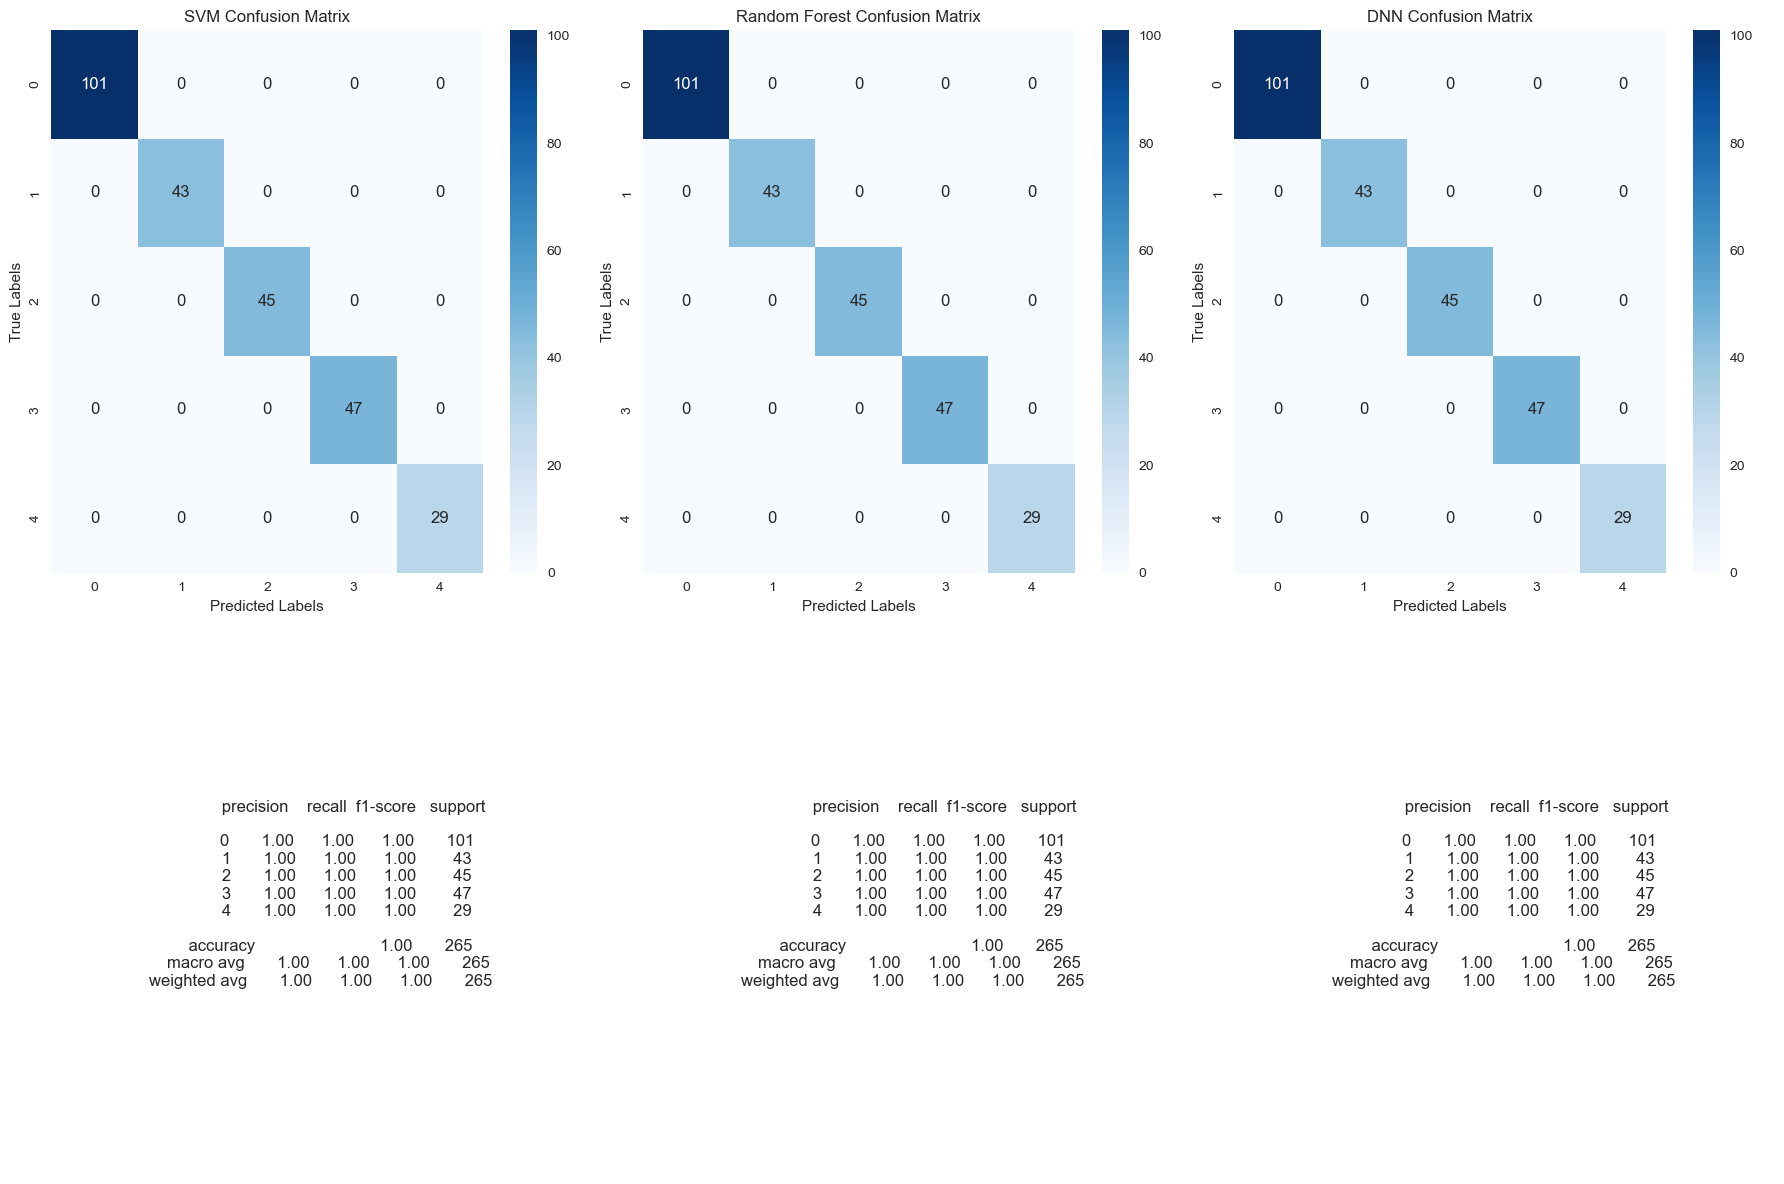

In [46]:
# Create subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Calculate the confusion matrix for SVM
svm_cm = confusion_matrix(y_test_svm, svm_pred)

# Plot the confusion matrix as a heatmap for SVM
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 0])
axes[0, 0].set_title("SVM Confusion Matrix")
axes[0, 0].set_xlabel("Predicted Labels")
axes[0, 0].set_ylabel("True Labels")

# Generate the classification report for SVM
svm_report = classification_report(y_test_svm, svm_pred)
axes[1, 0].text(0.5, 0.5, svm_report, {'verticalalignment': 'center', 'horizontalalignment': 'center', 'fontsize': 12}, transform=axes[1, 0].transAxes)
axes[1, 0].axis('off')

# Random Forest
# Calculate the confusion matrix for Random Forest
rf_cm = confusion_matrix(y_test_rfc, rf_pred)

# Plot the confusion matrix as a heatmap for Random Forest
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 1])
axes[0, 1].set_title("Random Forest Confusion Matrix")
axes[0, 1].set_xlabel("Predicted Labels")
axes[0, 1].set_ylabel("True Labels")

# Generate the classification report for Random Forest
rf_report = classification_report(y_test_rfc, rf_pred)
axes[1, 1].text(0.5, 0.5, rf_report, {'verticalalignment': 'center', 'horizontalalignment': 'center', 'fontsize': 12}, transform=axes[1, 1].transAxes)
axes[1, 1].axis('off')

# Calculate the confusion matrix for DNN
# Convert the one-hot encoded labels to categorical labels
y_test_classes = np.argmax(y_test_encoded_dnn, axis=1)

# Generate predictions on the test data
y_pred = model.predict(X_test_dnn)

y_pred_classes = np.argmax(y_pred, axis=1)

dnn_cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix as a heatmap for DNN
sns.heatmap(dnn_cm, annot=True, fmt="d", cmap="Blues", ax=axes[0, 2])
axes[0, 2].set_title("DNN Confusion Matrix")
axes[0, 2].set_xlabel("Predicted Labels")
axes[0, 2].set_ylabel("True Labels")

# Generate the classification report for DNN
dnn_report = classification_report(y_test_classes, y_pred_classes)
axes[1, 2].text(0.5, 0.5, dnn_report, {'verticalalignment': 'center', 'horizontalalignment': 'center', 'fontsize': 12}, transform=axes[1, 2].transAxes)
axes[1, 2].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

All three classification models achieved flawless performance in classifying gene expressions, as indicated by perfect scores of 1.00 for accuracy, recall, and precision.

## Validation

Perform hypothesis testing on the selected genes.

**Null Hypothesis:** Cancer types using tumor types (BRCA, KIRC, COAD, LUAD, & PRAD) cannot be correlated with the the genetic makeups in the dataset as there is no significant evidence. 

In [47]:
# Create a list to store the selected gene value expressions
selected_gene_values = []
# Access the embedding
tsne_embedding = tsne.embedding_
selected_genes_indices = np.argsort(tsne_embedding[:, 1])
# Retrieve gene names
gene_names = genes.columns
# Retrieve the names of the selected genes
selected_genes = gene_names[selected_genes_indices]
# Iterate over the selected gene names and retrieve their corresponding values from the original dataframe
for gene_name in selected_genes:
    gene_values = genes[gene_name].tolist()
    selected_gene_values.append(gene_values)

# Create a pandas DataFrame with the selected gene values
selected_genes_df = pd.DataFrame(selected_gene_values, columns=selected_genes)

# Add the labels to the DataFrame
selected_genes_df['Labels'] = cancers
selected_genes_df['KMeans_Labels'] = km_labels

selected_genes_df

,gene_9,gene_377,gene_231,gene_709,gene_184,gene_401,gene_788,gene_2,gene_205,gene_265,...,gene_132,gene_652,gene_54,gene_444,gene_308,gene_47,gene_383,gene_530,Labels,KMeans_Labels
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.067604,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,PRAD,2
1,8.042792,4.951005,4.042355,6.804957,8.992312,8.005086,7.197580,8.086778,7.418907,10.182655,...,8.781963,7.095239,9.315295,9.328540,6.658211,8.532703,8.786714,9.453898,LUAD,1
2,10.167694,0.000000,2.109829,5.191041,1.580097,6.158186,11.644185,12.701053,1.683921,7.912500,...,2.214653,8.839654,2.041944,0.496922,1.049282,6.103195,7.598030,4.324623,PRAD,2
3,5.853035,8.256671,7.733924,6.497528,7.767522,6.274778,6.472956,6.095068,7.329922,6.979374,...,7.283283,7.371193,6.609650,7.334336,7.963838,8.024807,6.365804,7.083447,PRAD,2
4,6.771120,6.385749,5.958147,4.377693,5.639504,4.404651,7.030524,6.213340,6.801120,3.514993,...,6.087603,5.281772,8.538755,3.386590,7.775630,8.379829,5.183498,5.210821,BRCA,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,6.128731,2.006585,4.858255,8.525991,7.400922,8.084819,5.068056,7.373431,3.778713,6.654715,...,7.864025,6.698927,5.127270,5.505053,7.539368,3.397064,8.711774,2.686904,BRCA,0
797,5.801490,5.468007,8.634807,4.160751,8.655516,6.149485,10.664785,8.866608,8.966673,5.801358,...,5.669333,8.412955,4.944573,8.357257,7.032828,7.118941,6.663174,6.035430,LUAD,1
798,9.769509,8.818521,9.286537,11.484455,10.050121,10.138029,9.931445,10.719132,10.618597,10.332428,...,9.591663,10.721501,10.361659,9.316494,9.353017,9.759286,9.967947,11.108956,COAD,4
799,12.456560,12.164932,12.686877,12.464316,10.657658,12.049025,11.193839,11.619353,11.031818,12.597033,...,10.255088,12.213627,11.037417,10.516281,12.171249,11.773424,13.069555,11.907311,PRAD,2


In [48]:
# Filter by class labels
class1_indices = cancers == 'PRAD'
class2_indices = cancers == 'LUAD'
class3_indices = cancers == 'BRCA'
class4_indices = cancers == 'COAD'
class5_indices = cancers == 'KIRC'
# Filter the t-SNE embedding vectors based on class labels
class1_embedding = tsne_embedding[class1_indices]
class2_embedding = tsne_embedding[class2_indices]
class3_embedding = tsne_embedding[class3_indices]
class4_embedding = tsne_embedding[class4_indices]
class5_embedding = tsne_embedding[class5_indices]

In [49]:
# Perform ANOVA
f_stat, p_value = stats.f_oneway(class1_embedding[:, 0], class2_embedding[:, 0], class3_embedding[:, 0], class4_embedding[:, 0], class5_embedding[:, 0])

# Print the results
print("F-Statistic:", f_stat)
print("p-value:", p_value)

F-Statistic: 3124.972303501715
p-value: 0.0


In [50]:
# Group samples based off tumor type
brca_df = selected_genes_df[selected_genes_df['Labels'] == 'BRCA'].select_dtypes(include=np.number)
kirc_df = selected_genes_df[selected_genes_df['Labels'] == 'KIRC'].select_dtypes(include=np.number)
coad_df = selected_genes_df[selected_genes_df['Labels'] == 'COAD'].select_dtypes(include=np.number)
luad_df = selected_genes_df[selected_genes_df['Labels'] == 'LUAD'].select_dtypes(include=np.number)
prad_df = selected_genes_df[selected_genes_df['Labels'] == 'PRAD'].select_dtypes(include=np.number)

# Find mean value expression for each tumor type
brca = brca_df.mean()
kirc = kirc_df.mean()
coad = coad_df.mean()
prad = prad_df.mean()
luad = luad_df.mean()
# Create a dataframe with mean values
means_df = pd.DataFrame({'BRCA': brca, 'KIRC': kirc, 'COAD': coad, 'PRAD': prad, 'LUAD': luad})
# Format df with pd.melt
format_df = pd.melt(means_df, var_name='Cancer_Type', value_name='Gene_Expression')

# Create ANOVA model
model = ols('Gene_Expression ~ C(Cancer_Type)', data=format_df).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model)
# See ANOVA
anova_table

,df,sum_sq,mean_sq,F,PR(>F)
C(Cancer_Type),4.0,374.756134,93.689034,1047.280031,0.0
Residual,4005.0,358.284860,0.089459,NaN,NaN


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  BRCA   COAD   0.3723    0.0  0.3315   0.413   True
  BRCA   KIRC   0.6379    0.0  0.5971  0.6787   True
  BRCA   LUAD  -0.0057 0.9956 -0.0464  0.0351  False
  BRCA   PRAD  -0.2153    0.0  -0.256 -0.1745   True
  COAD   KIRC   0.2656    0.0  0.2249  0.3064   True
  COAD   LUAD  -0.3779    0.0 -0.4187 -0.3372   True
  COAD   PRAD  -0.5875    0.0 -0.6283 -0.5468   True
  KIRC   LUAD  -0.6436    0.0 -0.6843 -0.6028   True
  KIRC   PRAD  -0.8531    0.0 -0.8939 -0.8124   True
  LUAD   PRAD  -0.2096    0.0 -0.2503 -0.1688   True
----------------------------------------------------


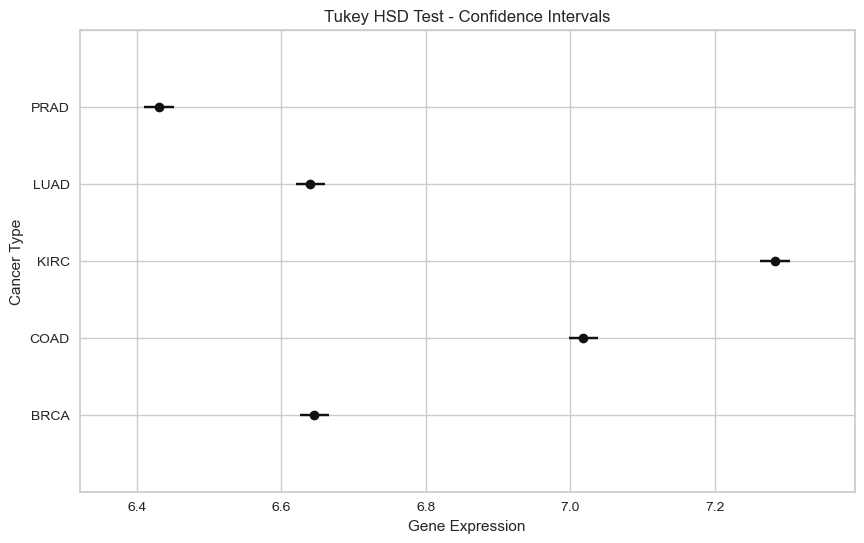

In [51]:
multi_comp = MultiComparison(format_df['Gene_Expression'], format_df['Cancer_Type'])
tukey_results = multi_comp.tukeyhsd()
tukey_results.plot_simultaneous()
plt.xlabel('Gene Expression')
plt.ylabel('Cancer Type')
plt.title('Tukey HSD Test - Confidence Intervals')
print(tukey_results)
plt.show()

Based on the results of the Tukey's HSD test, we can conclude that there are significant differences in gene expression among the tumor types. The following pairwise comparisons showed statistically significant differences in mean gene expression: BRCA vs COAD, BRCA vs KIRC, BRCA vs PRAD, COAD vs KIRC, COAD vs LUAD, COAD vs PRAD, KIRC vs LUAD, KIRC vs PRAD, and LUAD vs PRAD. These findings indicate that the gene expression profiles vary significantly between these tumor types, suggesting potential differences in underlying biological mechanisms or disease characteristics. These results provide valuable insights into the distinct molecular features associated with each tumor type, which can aid in further understanding and characterization of these cancers.